# Analysis of the number of teachers in German federal states

## 0. Introduction and Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import school_analysis as sa
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb

## 1. Data Import and Preparation

In [2]:
import warnings


def load_table(path: str = "data/raw/allgemeinbildende-schulen.xlsx", sheet_name: str = "Tab. 7.1") -> pd.DataFrame:
    """Load table from destatis excel file"""
    df = pd.read_excel(os.path.join(sa.PROJECT_PATH ,path), sheet_name=sheet_name, header=5, skipfooter=45, engine="openpyxl")
    zmw_col = df.columns[1]
    nested_ser = df[df[zmw_col].isna() == 1][df.columns[0]]
    school_ser = df[df[zmw_col] == "z"][df.columns[0]]
    
    # Preprocess such that all rows have the same values for the columns "School Type", "Contract Type" and "Federal State"
    
    # ---- School Type ----
    df["School Type"] = np.nan
    for index, value in school_ser.items():
        df.iloc[index, -1] = value
        df.iloc[index+1, -1] = value
        df.iloc[index+2, -1] = value
    
    # ---- Contract Type ----
    df["Contract Type"] = np.nan
    counter = 0
    new_nested_ser = nested_ser.copy()
    for index, value in nested_ser.items():
        if counter % 4 == 0:
            counter += 1
            continue
        
        times = nested_ser.index.tolist()[counter + 1] - index - 1 if counter + 1 < len(nested_ser) else len(df) - index - 1
        for i in range(times):
            df.iloc[index + 1 + i, -1] = value
        
        new_nested_ser = new_nested_ser.drop(index)
        counter += 1
    
    # ---- Federal State ----
    df["Federal State"] = np.nan
    counter = 0
    for index, value in new_nested_ser.items():
        times = new_nested_ser.index.tolist()[counter + 1] - index - 2 if counter + 1 < len(new_nested_ser) else len(df) - index - 2
        for i in range(times):
            df.iloc[index + 2 + i, -1] = value
        counter += 1
    
    # Preprocess the data into the melted format
    df = df[df["School Type"].isna() == 0]
    df = df[df.columns[-3:].tolist() + df.columns[:-3].tolist()]
    df = df.drop(columns=[df.columns[3]])
    df.rename(columns={df.columns[3]: "Gender"}, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = df.melt(id_vars=df.columns[:4].tolist(), value_vars=df.columns[4:].tolist(), var_name="Year", value_name="Number of Teachers")
    return df

# Load the data and display it
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = load_table()
data
data_without_ger = data[data["Federal State"] != "Deutschland"]
germany = data[data["Federal State"] == "Deutschland"]

# Plot the number of teachers per federal state per year

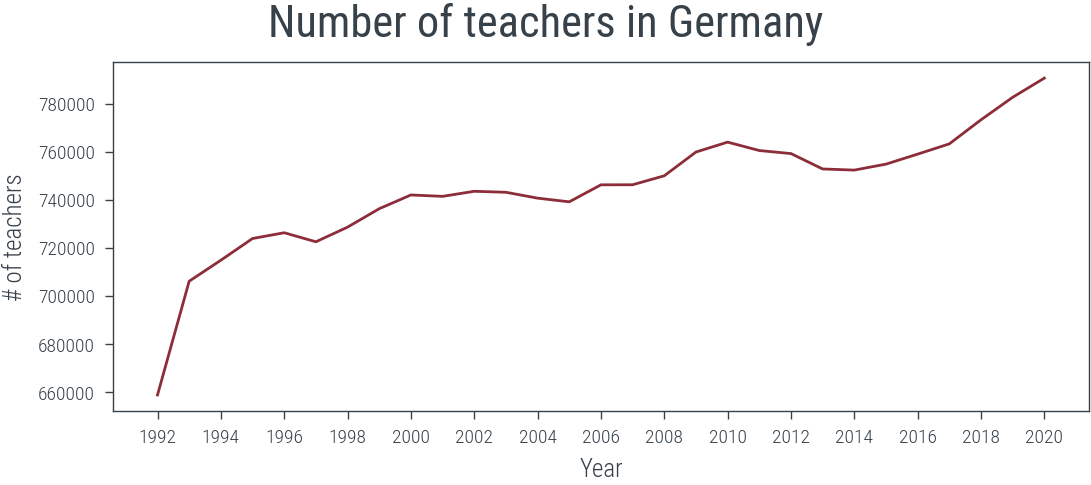

In [3]:
# Plot the data
fig, ax = plt.subplots(1, 1)

aggregated = germany[["Gender", "Number of Teachers", "Year"]].groupby(["Gender", "Year"]).sum().reset_index()
male = aggregated.loc[aggregated["Gender"] == "m"]
female = aggregated.loc[aggregated["Gender"] == "w"]
all = aggregated.loc[aggregated["Gender"] == "z"]

ax.plot(all["Year"], all["Number of Teachers"])

ax.set_xlabel("Year")
ax.set_ylabel("# of teachers")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))

# Other settings
fig.suptitle("Number of teachers in Germany", fontsize=16)

plt.show()

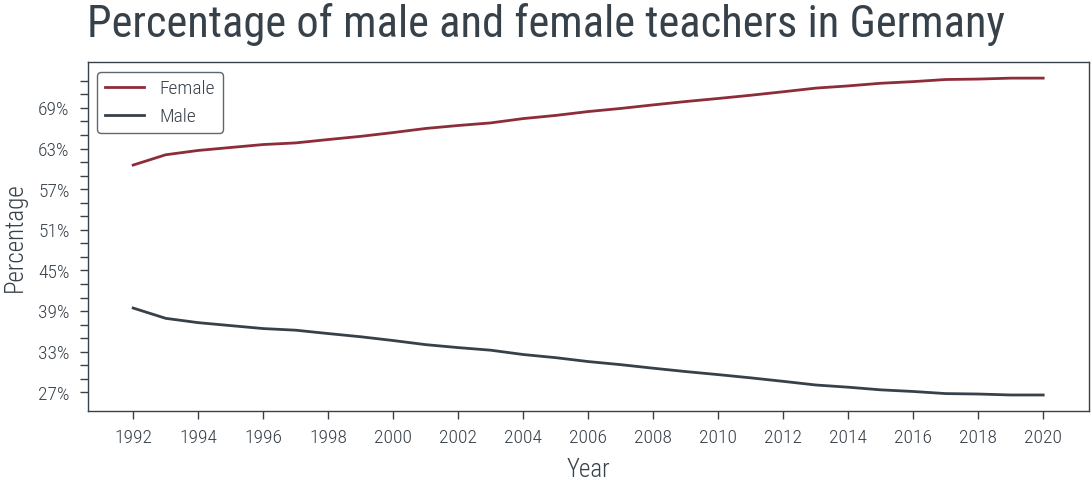

In [4]:
# Plot the data
fig, ax = plt.subplots(1, 1)

aggregated = germany[["Gender", "Number of Teachers", "Year"]].groupby(["Gender", "Year"]).sum().reset_index()
male = aggregated.loc[aggregated["Gender"] == "m"]
female = aggregated.loc[aggregated["Gender"] == "w"]
all = aggregated.loc[aggregated["Gender"] == "z"]

f_per = female["Number of Teachers"].to_numpy() / all["Number of Teachers"].to_numpy() * 100
m_per = male["Number of Teachers"].to_numpy() / all["Number of Teachers"].to_numpy() * 100

ax.plot(all["Year"], f_per)
ax.plot(all["Year"], m_per)

ax.set_xlabel("Year")
ax.set_ylabel("Percentage")
ax.legend(["Female", "Male"])
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 2))
yticks = np.arange(round(m_per.min()), round(f_per.max() + 1), 2)
ax.set_yticks(yticks, [f'{int(tick)}%' if tick.is_integer() and tick % 3 == 0 else '' for tick in yticks])

# Other settings
fig.suptitle("Percentage of male and female teachers in Germany", fontsize=16)

plt.show()